In [1]:
%reset -f
%matplotlib inline
import sys
sys.path.append('/home/anirudh/Academia/projects/vep.stan')
import numpy as np
import lib.io.stan
import lib.plots.stan
import lib.utils.stan
import subprocess
import matplotlib.pyplot as plt
import os 
from matplotlib.lines import Line2D
import importlib

In [2]:
data_dir = '/home/anirudh/Academia/projects/vep.stan/datasets/id002_cj'
results_dir = '/home/anirudh/Dropbox/Academia/projects/VEP/results/exp12'
os.makedirs(results_dir,exist_ok=True)
os.makedirs(f'{results_dir}/logs',exist_ok=True)
os.makedirs(f'{results_dir}/figures',exist_ok=True)

network = np.load(f'{data_dir}/CJ_network.npz')
SC = network['SC']
K = np.max(SC)
SC = SC / K
SC[np.diag_indices(SC.shape[0])] = 0
gain_mat = network['gain_mat']

slp = np.load(f'{data_dir}/CJ_fit_trgt.npz')['fit_trgt']
slp_ds = slp[0:-1:10,:]
snsr_pwr = np.sum(slp_ds**2, axis=0)

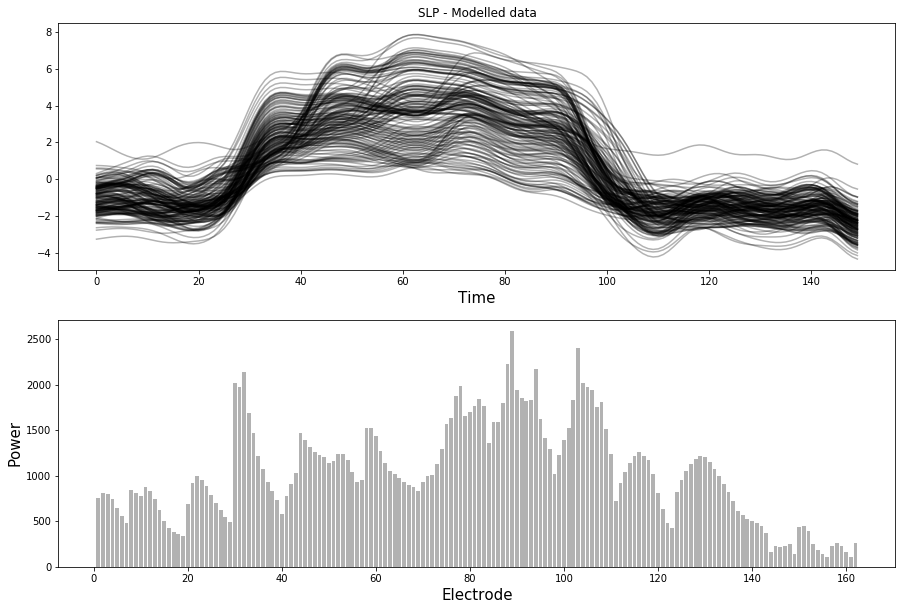

In [3]:
plt.figure(figsize=(15,10))
plt.subplot(211)
plt.plot(slp_ds, color='black', alpha=0.3);
plt.xlabel('Time', fontsize=15)
plt.title('SLP - Modelled data')
plt.subplot(212)
plt.bar(np.arange(1,gain_mat.shape[0]+1), snsr_pwr, color='black', alpha=0.3)
plt.xlabel('Electrode', fontsize=15)
plt.ylabel('Power', fontsize=15)
plt.savefig(f'{results_dir}/figures/fitting_data.png')

In [4]:
nn = SC.shape[0]
ns = gain_mat.shape[0]
nt = slp_ds.shape[0]
I1 = 3.1
time_step = 0.1
x_init = -2.0*np.ones(nn)
z_init = 3.5*np.ones(nn)
epsilon_slp = 0.1
epsilon_snsr_pwr = 5


x0_star = np.zeros(nn)
amplitude_star = 0.0
offset = 0.0
K_star = 0.0
tau0_star = 0.0


param_init = {'x0_star':x0_star, 'amplitude_star':amplitude_star, 'offset':offset,
              'K_star':K_star, 'tau0_star':tau0_star}
param_init_file = 'param_init.R'
os.makedirs(f'{results_dir}/Rfiles',exist_ok=True)
lib.io.stan.rdump(f'{results_dir}/Rfiles/param_init.R',param_init)

ez_idx = 7
hyp = {'ez':{'mean':-1.5,'sd':0.01},
       'pz':{'mean':-2.5,'sd':0.01},
       'hz':{'mean':-3.5,'sd':0.01}}

for hyp_type, x0 in hyp.items():
    data = {'nn':nn, 'ns':ns, 'nt':nt, 'I1':I1, 'time_step':time_step,
            'ez_idx': ez_idx, 'x0_mean_hyp':x0['mean'], 'x0_sd_hyp':x0['sd'],
            'SC':SC, 'gain': gain_mat, 'x_init':x_init, 'z_init':z_init,
            'epsilon_slp':epsilon_slp, 'epsilon_snsr_pwr':epsilon_snsr_pwr,
            'slp':slp_ds, 'snsr_pwr':snsr_pwr}
    Rfname = f'fit_data_{hyp_type}.R'
    os.makedirs(f'{results_dir}/Rfiles',exist_ok=True)
    lib.io.stan.rdump(f'{results_dir}/Rfiles/{Rfname}',data)